# Exploratory Data Analysis

In [1]:
#Summary of loading the training data
import pandas as pd

# Load training data
train_path = "/kaggle/input/System-Threat-Forecaster/train.csv"
train_df = pd.read_csv(train_path)

# Basic info
num_rows, num_cols = train_df.shape
missing_values = train_df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

# Separate numerical and categorical columns
num_features = train_df.select_dtypes(include=['number']).columns.tolist()
cat_features = train_df.select_dtypes(include=['object']).columns.tolist()

# Target distribution
target_counts = train_df['target'].value_counts(normalize=True) * 100

# Summary
eda_summary = {
    "Total Rows": num_rows,
    "Total Columns": num_cols,
    "Missing Values (Top 10)": missing_values.head(10).to_dict(),
    "Numerical Features": len(num_features),
    "Categorical Features": len(cat_features),
    "Target Distribution (%)": target_counts.to_dict()
}

eda_summary

{'Total Rows': 100000,
 'Total Columns': 76,
 'Missing Values (Top 10)': {'SMode': 981,
  'CityID': 623,
  'IsGamer': 559,
  'RegionIdentifier': 559,
  'InternalBatteryNumberOfCharges': 515,
  'FirmwareManufacturerID': 376,
  'FirmwareVersionID': 334,
  'IsFlightsDisabled': 326,
  'OEMModelID': 228,
  'OEMNameID': 212},
 'Numerical Features': 48,
 'Categorical Features': 28,
 'Target Distribution (%)': {1: 50.525, 0: 49.475}}

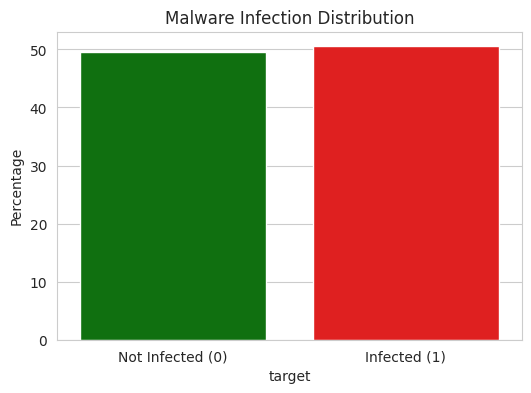

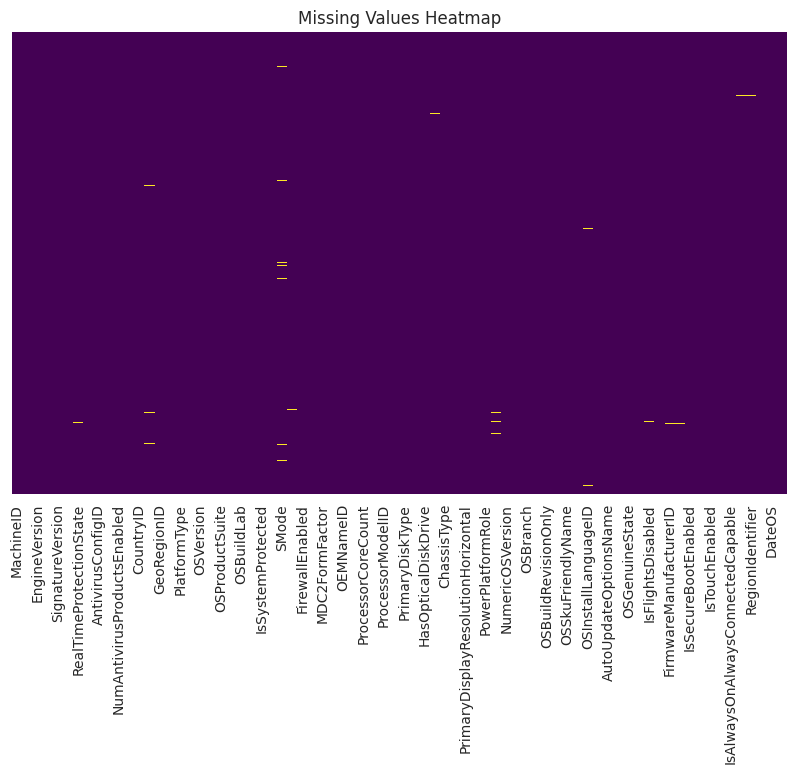

In [2]:
# Plot Target Distribution and Missing Values Heatmap
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")

plt.figure(figsize=(6, 4))
sns.barplot(x=target_counts.index, y=target_counts.values, palette=["green", "red"])
plt.xticks([0, 1], ["Not Infected (0)", "Infected (1)"])
plt.ylabel("Percentage")
plt.title("Malware Infection Distribution")
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(train_df.isnull(), cmap="viridis", cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

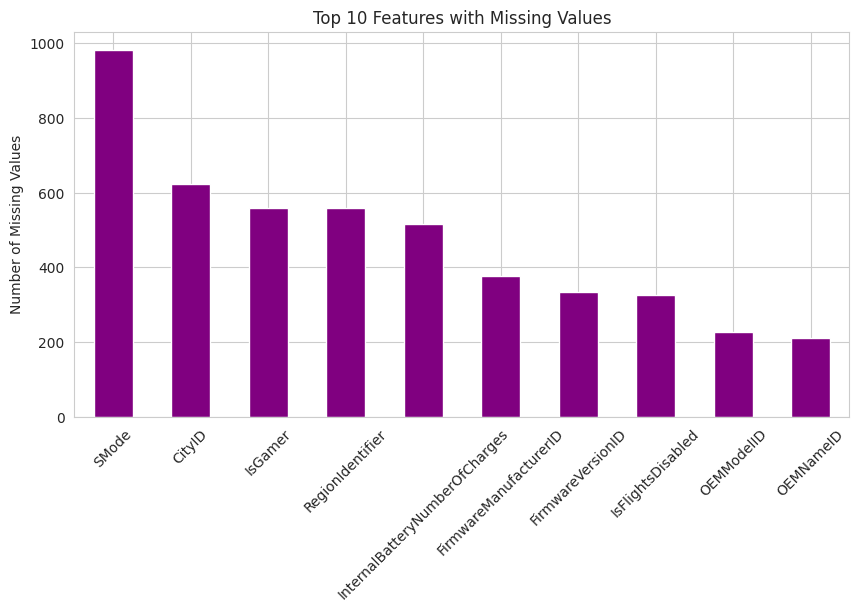

In [3]:
# Plot Missing Values as a Bar Chart
plt.figure(figsize=(10, 5))
missing_values.head(10).plot(kind="bar", color="purple")
plt.ylabel("Number of Missing Values")
plt.title("Top 10 Features with Missing Values")
plt.xticks(rotation=45)
plt.show()

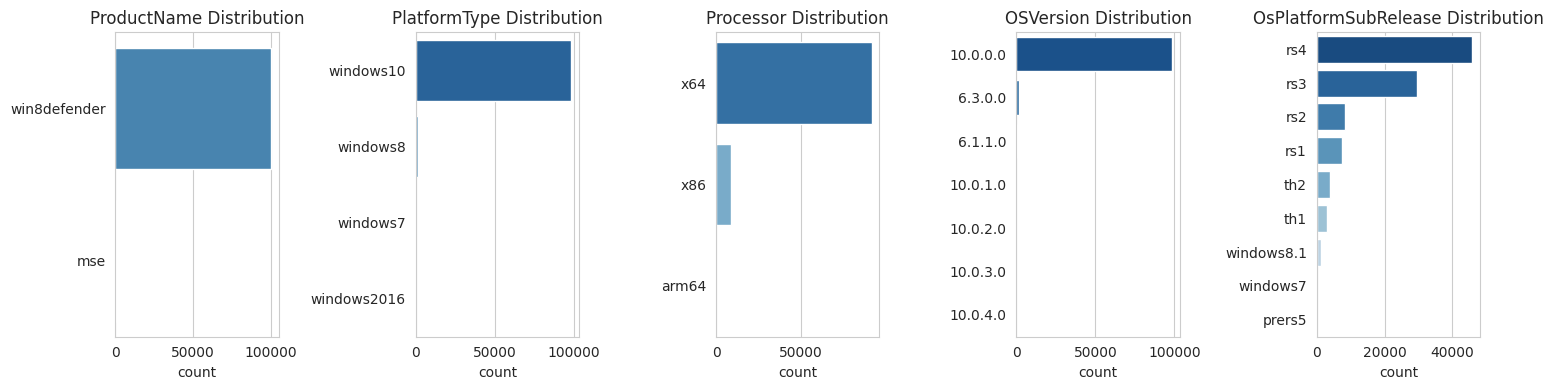

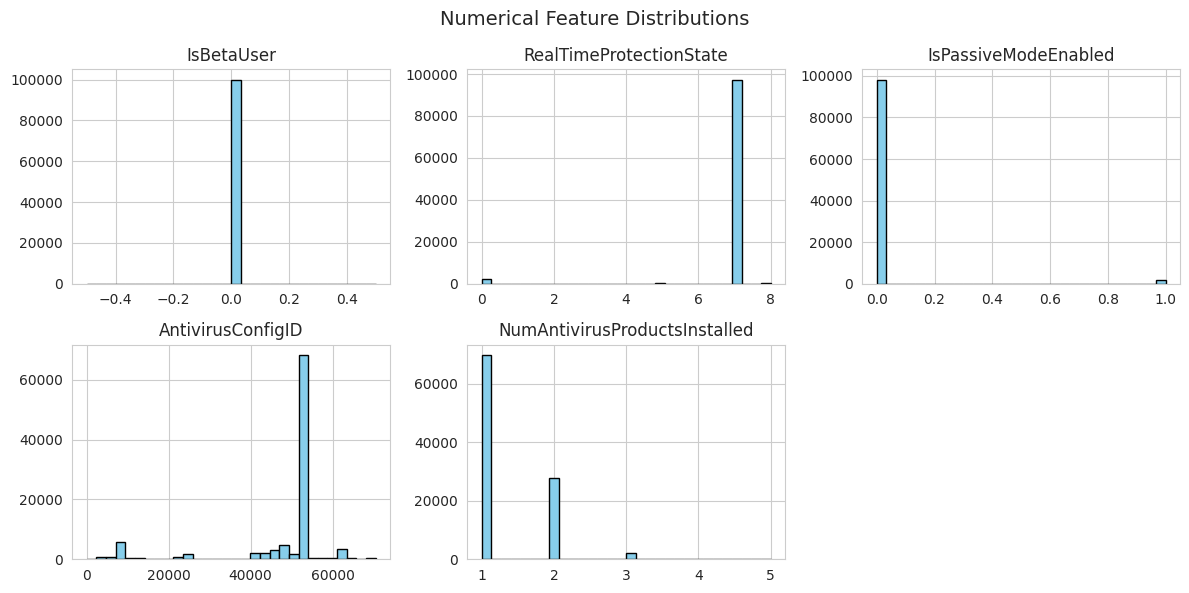

In [4]:
# Plot histograms of numerical features (sample 5 for readability)

# Select top categorical columns by uniqueness (avoiding high-cardinality ones)
top_cat_features = [col for col in cat_features if train_df[col].nunique() < 15][:5]  # Picking 5 with <15 unique values

# Plot top categorical feature distributions
fig, axes = plt.subplots(1, len(top_cat_features), figsize=(15, 4))
for col, ax in zip(top_cat_features, axes):
    sns.countplot(y=train_df[col], order=train_df[col].value_counts().index, ax=ax, palette="Blues_r")
    ax.set_title(f"{col} Distribution")
    ax.set_ylabel("")

plt.tight_layout()
plt.show()

sample_num_features = num_features[:5]  # Pick first 5 numerical features

train_df[sample_num_features].hist(figsize=(12, 6), bins=30, layout=(2, 3), edgecolor='black', color='skyblue')
plt.suptitle("Numerical Feature Distributions", fontsize=14)
plt.tight_layout()
plt.show()

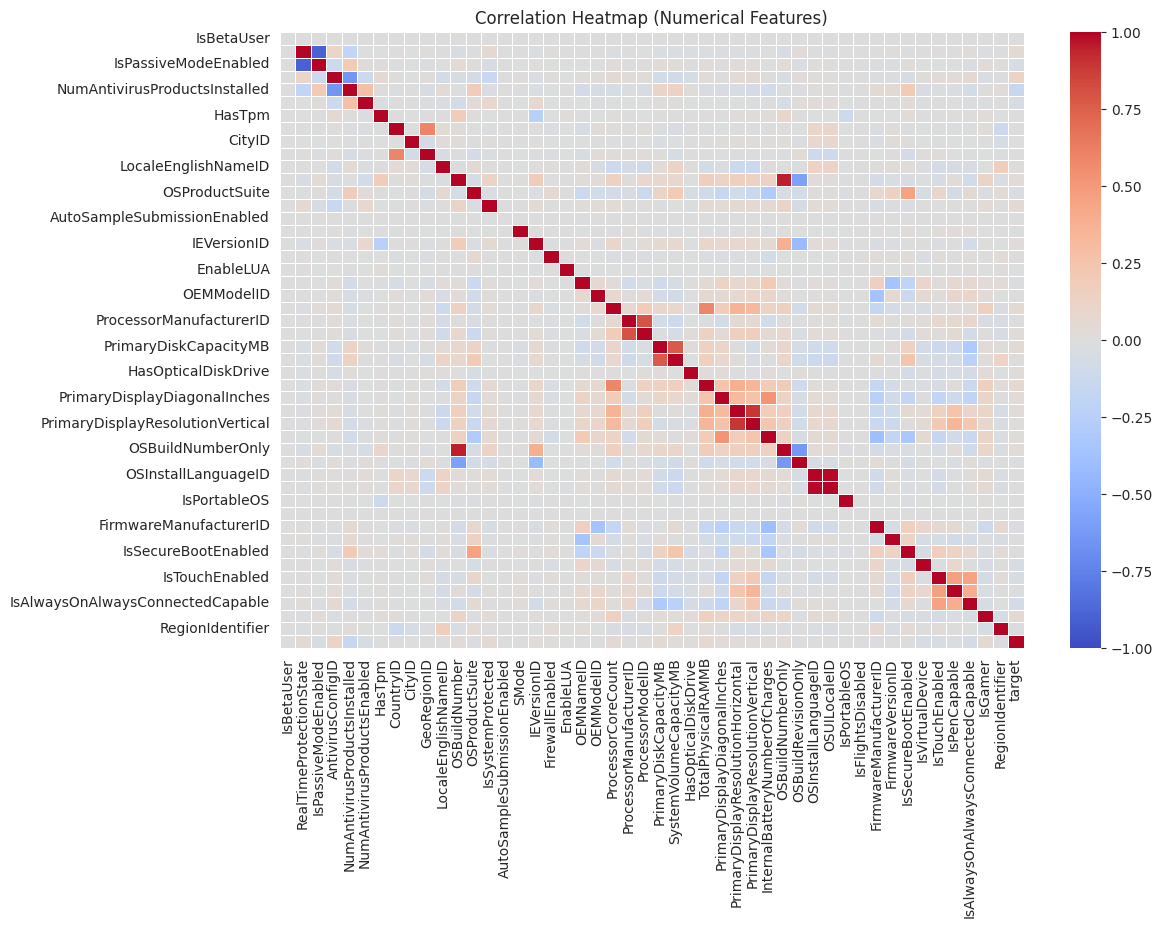

In [5]:
# Plot Correlation Heatmap (only for strong correlations)

# Compute correlation matrix for numerical features
corr_matrix = train_df[num_features].corr()

# Replace NaNs with 0 (optional: drop features with all NaNs before correlation calculation)
corr_matrix = corr_matrix.fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, linewidths=0.5, vmin=-1, vmax=1)
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()

# PreProcessing

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Load datasets
train_path = "/kaggle/input/System-Threat-Forecaster/train.csv"
test_path = "/kaggle/input/System-Threat-Forecaster/test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Reduce memory usage
def reduce_memory(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type == 'int64':
            df[col] = df[col].astype('int32')
        elif col_type == 'float64':
            df[col] = df[col].astype('float32')
    return df

train_df = reduce_memory(train_df)
test_df = reduce_memory(test_df)

# Drop ID column
train_df.drop(columns=["MachineID"], inplace=True)
test_ids = test_df["MachineID"]  # Save test IDs
test_df.drop(columns=["MachineID"], inplace=True)

# Separate features and target
X = train_df.drop(columns=["target"])
y = train_df["target"]

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=["object"]).columns
numerical_cols = X.select_dtypes(include=["int32", "float32"]).columns

# Handle missing values
imputer = SimpleImputer(strategy="most_frequent")
X[numerical_cols] = imputer.fit_transform(X[numerical_cols])
test_df[numerical_cols] = imputer.transform(test_df[numerical_cols])

# Encode categorical variables
ordinal_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
X[categorical_cols] = ordinal_encoder.fit_transform(X[categorical_cols])
test_df[categorical_cols] = ordinal_encoder.transform(test_df[categorical_cols])

# Scale numerical features
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
test_df[numerical_cols] = scaler.transform(test_df[numerical_cols])

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training

In [7]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score

sample_submission_path = "/kaggle/input/System-Threat-Forecaster/sample_submission.csv"
sample_submission = pd.read_csv(sample_submission_path)

# Train a memory-efficient model
model = HistGradientBoostingClassifier(max_iter=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# Validate the model
y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

# Make predictions on the test set
test_predictions = model.predict(test_df)

# Create submission file
submission = sample_submission.copy()
submission['target'] = test_predictions

# Save submission to CSV
submission_file_path = 'submission.csv'
submission.to_csv(submission_file_path, index=False)
print("Submission file saved as submission.csv")

# Display the saved submission
submission_file = pd.read_csv(submission_file_path)
submission_file

Validation Accuracy: 0.6284
Submission file saved as submission.csv


,id,target
0,0,1
1,1,0
2,2,1
3,3,0
4,4,0
...,...,...
9995,9995,0
9996,9996,1
9997,9997,0
9998,9998,1
